# Lab 6 - Network Optimization Models - The Minimum Spanning Tree Problem

<b>Information on group members:</b><br>
1) Samuel Janas 151927 <br>
2) Bruno Urbaniak 151955 <br>

In [54]:
%matplotlib inline
import csv
import matplotlib.pyplot as plt

1.1) Get acquainted with the below "City" class definition. It has three major fields: name, city's longitude, and latitude. The coordinate's input is in the format "00°00'E/N," and it is converted to a list [degrees, minutes]. Also, these coordinates are also simply converted and stored as x and y coordinates. 

In [55]:
class City:
    def __init__(self, name, long, lat):
        self.name = name
        self.long = [float(long.split("°")[0]), float(long.split("°")[1].replace("'",'').replace("E",''))]
        self.x = self.long[0]*60 + self.long[1]
        self.lat = [float(lat.split("°")[0]), float(lat.split("°")[1].replace("'",'').replace("N",''))]  
        self.y = self.lat[0]*60 + self.lat[1]
       
    def __repr__(self):
        return str(self.name) + " " + str(self.lat) + " " + str(self.long)

1.2) The below piece of code loads cities data from the cities.csv file and creates a list of cities. 

In [56]:
cities = []

with open('cities.csv', newline='', encoding="utf-8") as csvfile:
    r = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in r:
        cities.append(City(row[0], row[1], row[2]))
        
for c in cities[:10]: ### TEST
    print(c)

Adamów (siedleckie) [51.0, 45.0] [22.0, 15.0]
Adamów (zamojskie) [50.0, 36.0] [23.0, 10.0]
Adamówka [50.0, 16.0] [22.0, 42.0]
Aleksandrów [51.0, 16.0] [19.0, 59.0]
Aleksandrów Kujawski [52.0, 53.0] [18.0, 42.0]
Aleksandrów Łódzki [51.0, 49.0] [19.0, 19.0]
Alwernia [50.0, 4.0] [19.0, 32.0]
Andrespol [51.0, 44.0] [19.0, 37.0]
Andrychów [49.0, 52.0] [19.0, 20.0]
Andrzejewo [52.0, 50.0] [22.0, 12.0]


1.3) The function below plots all cities according to their X and Y coordinates. Note that there are so many cities that Poland's boundaries can be observed. Feel free to modify the code. The unrequired input "edges" is a list of pairs of indices indicating edges to be drawn. 

In [57]:
# spectral color map
cmap = 'Spectral'

spectral = plt.cm.get_cmap(cmap, 10)

# Extract 10 discrete colors
spectral_colors = [spectral(i) for i in range(spectral.N)]

# Convert colors to RGB format
spectral_rgb = [(round(color[0], 3), round(color[1], 3), round(color[2], 3)) for color in spectral_colors]

print(spectral_rgb)

[(0.62, 0.004, 0.259), (0.849, 0.264, 0.305), (0.965, 0.484, 0.289), (0.993, 0.748, 0.435), (0.998, 0.932, 0.636), (0.946, 0.978, 0.664), (0.748, 0.898, 0.627), (0.46, 0.784, 0.646), (0.219, 0.559, 0.731), (0.369, 0.31, 0.635)]


C:\Users\samue\AppData\Local\Temp/ipykernel_13416/3726462376.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spectral = plt.cm.get_cmap(cmap, 10)


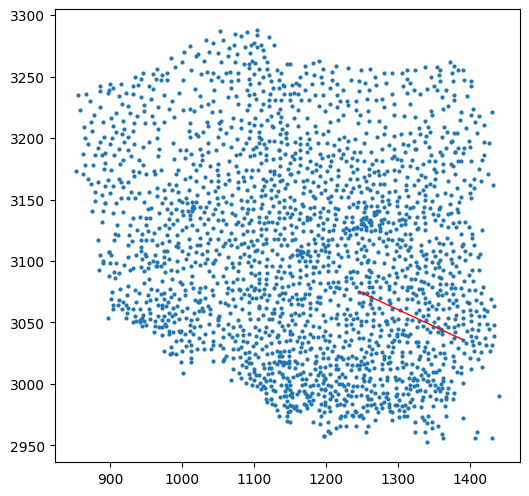

In [58]:
def plotMap(cities, edges, use_gradient=False):
    fig = plt.figure(figsize=(6,6), dpi=100, facecolor='w', edgecolor='k')
    
    # Plot the cities
    X = [c.x for c in cities]
    Y = [c.y for c in cities]
    plt.plot(X, Y, ms=2, ls="", marker="o")


    # Function to interpolate between red and light green
    def interpolate_color(step, total_steps):
        # Define the RGB values for the specified colors
        colors = [(0.62, 0.004, 0.259), (0.849, 0.264, 0.305), (0.965, 0.484, 0.289), (0.993, 0.748, 0.435), (0.998, 0.932, 0.636), (0.946, 0.978, 0.664), (0.748, 0.898, 0.627), (0.46, 0.784, 0.646), (0.219, 0.559, 0.731), (0.369, 0.31, 0.635)]

        # Calculate the number of transitions
        num_transitions = len(colors) - 1

        # Calculate the steps per transition
        steps_per_transition = total_steps / num_transitions

        # Determine the current transition and calculate the mix ratio
        current_transition = int(step // steps_per_transition)
        mix_ratio = (step % steps_per_transition) / steps_per_transition

        # Handle the case when the step is exactly at the end of the total_steps
        if current_transition == num_transitions:
            return colors[-1]

        # Interpolate between the current and the next color
        start_color = colors[current_transition]
        end_color = colors[current_transition + 1]
        return [start_color[i] * (1 - mix_ratio) + end_color[i] * mix_ratio for i in range(3)]

    total_steps = len(edges)

    # Plot each edge with its corresponding gradient color
    for i, edge in enumerate(edges):
        if use_gradient:
            color = interpolate_color(i, total_steps - 1)
        else:
            color = "red"
        X = [cities[edge[0]].x, cities[edge[1]].x]
        Y = [cities[edge[0]].y, cities[edge[1]].y]
        plt.plot(X, Y, lw=1, ls="-", marker="", color=color)


    plt.show()


plotMap(cities, edges=[[1, 200]])

1.3) The dataset consists of 2249 cities. It may be too much when it comes to implementing the algorithm for constructing the minimum spanning tree (computational burden). Therefore, you can consider only every n-th row from the dataset to ensure that the computations will be completed in a reasonable time. 

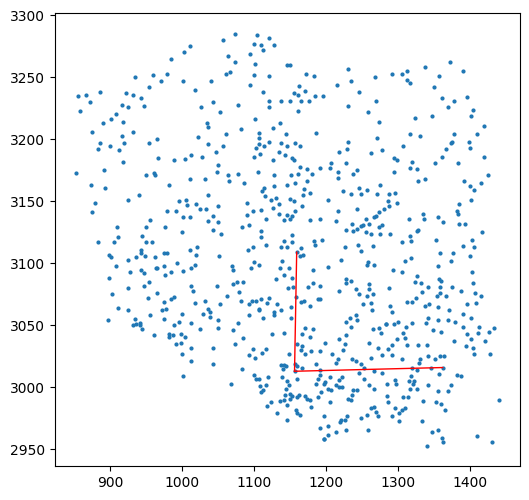

In [59]:
n = 3
cities_small = cities[2::n]
plotMap(cities_small, edges=[[0,200], [1, 200]])

1.4) Finish the function below for constructing a distance matrix. Each i-th row should contain distances from the i-th city to other cities. For convenience and to improve the algorithm's computational complexity for constructing the spanning tree, it is suggested to keep rows sorted according to distance. Rows may contain information on the j-th indices of the respective destinations along with the distances in a tuple (j-th indice, distance). 

You can use the Euclidean distance for computations. You can use the x and .y fields that store the geographical coordinates. This way of formulating a distance does not have much sense because the computation would be based on angles. Nonetheless, it is allowed in this exercise to do so, but if you wish, you can calculate the distances correctly by computing arc lengths between two points on a sphere - Earth. 

In [60]:
import numpy as np

In [61]:
def getSortedDistances(c):
    # create a matrix of tuples (distance, to_city) for each city
    # in row 0, there are the distances from city 0 to all other cities
    D = []
    for i in range(len(c)):
        D.append([])
        for j in range(len(c)):
            if i != j:
                D[i].append((np.sqrt((c[i].x-c[j].x)**2 + (c[i].y-c[j].y)**2), j))

    # sort the tuples in each row by distance
    for i in range(len(D)):
        D[i].sort()
    return D


D = getSortedDistances(cities)
print(D[0][:5])

[(4.123105625617661, 2107), (4.242640687119285, 855), (5.0, 1630), (8.54400374531753, 1735), (9.219544457292887, 621)]


1.5) Auxiliary function for finding a corresponding index in the data set for a provided city name. 

In [62]:
def getIdx(name, cities):
    for i, c in enumerate(cities):
        if name == c.name: return i
    return None

print(getIdx("Hel", cities))

536


1.6) Complete the below greedy algorithm for constructing the minimum spanning tree. As an input, it should return a list of edges of the constructed subgraph, which can then be used in the plotMap function to show the tree structure. You can set the city of Hel as an initial node. 

In [67]:
import heapq

def getSpanningTree(startingNode, cities, D):
    N = len(cities)
    IN_TREE = set([startingNode])
    edges = []

    # Create a priority queue to store edges along with their weights
    edge_queue = []
    for dist, to_city in D[startingNode]:
        heapq.heappush(edge_queue, (dist, startingNode, to_city))

    while len(IN_TREE) < N:
        # Get the smallest edge from the queue
        dist, from_city, to_city = heapq.heappop(edge_queue)

        # If the destination city is not in the tree, add the edge to the tree
        if to_city not in IN_TREE:
            IN_TREE.add(to_city)
            edges.append([from_city, to_city])

            # Add all edges from the new city to the queue
            for new_dist, new_to_city in D[to_city]:
                if new_to_city not in IN_TREE:
                    heapq.heappush(edge_queue, (new_dist, to_city, new_to_city))

    return edges


edges = getSpanningTree(getIdx("Hel", cities), cities, D)

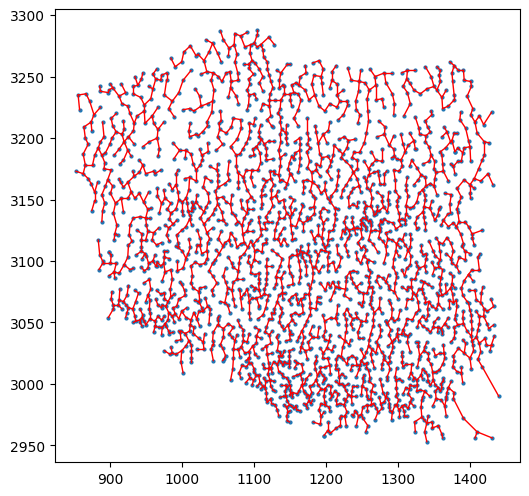

In [64]:
plotMap(cities, edges=edges, use_gradient=False)

In [65]:
# FIXME: Some cities are not from Poland
for city in cities:
    # find 10 cities with the smallest y coordinate
    if city.y < 3015 and city.x > 1402:
        print(city)

Borysław [49.0, 16.0] [23.0, 27.0]
Drohobycz [49.0, 21.0] [23.0, 30.0]
Lwów [49.0, 50.0] [24.0, 0.0]
Rawa Ruska [50.0, 14.0] [23.0, 37.0]
Stryj [49.0, 16.0] [23.0, 51.0]


1.6) Modify the code so that it displays the results after 10 intermediate steps. In this way, you can get a better insight into how the algorithm constructs the spanning tree. Additionally, you can use, e.g., a gradient to distinguish between different iterations of the algorithm when plotting the map (e.g., 1-st iteration = 100% red, last iteration == 100% green). 

---
See gradient in the exercise before

It goes from the gradient is described in the colors list of `plotMap` function

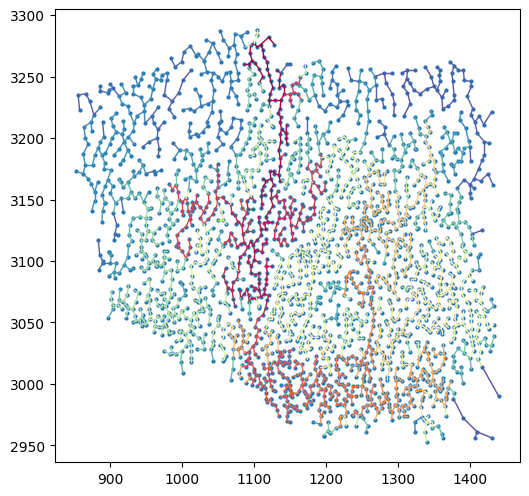

In [68]:
plotMap(cities, edges=edges, use_gradient=True)